# cifar-10 cnn

## imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## devices

In [2]:
def get_available_pus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_pus()

['/cpu:0']

## data

In [3]:
def unpickle(file):
    with open(file, "rb") as f:
        data_map = pickle.load(f, encoding="bytes")
    return data_map

In [4]:
data = unpickle("../my_datasets/cifar-10-batches-py/data_batch_1")

In [5]:
#10000 images, 1024 pixels (and 3 color channels, 1024 * 3)
data[b"data"].shape

(10000, 3072)

In [6]:
type(data[b"data"])

numpy.ndarray

In [7]:
num_images = data[b"data"].shape[0]
num_pixels = int(data[b"data"].shape[1] / 3)
num_colors = 3
img_dim = [int(num_pixels ** .5)] * 2
print("images: {}\ndimensions: {}\npixels: {}\ncolors: {}".format(
    num_images, img_dim, num_pixels, num_colors
))

images: 10000
dimensions: [32, 32]
pixels: 1024
colors: 3


### reshaping the data
We'll start by reshaping the 2nd dimension of each image to be of shape (3, 1024), where all red features are (0, ?), all green are (1, ?) and all blue are (2, ?). The shape of the entire dataset should afterwards be (10000, 1024, 3).

In [8]:
features = np.asarray(
    list(
        map(
            lambda img: [
                [img[i], img[num_pixels + i], img[2*num_pixels + i]] for i in range(num_pixels)
            ],
            data[b"data"]
        )
    )
)
#).reshape(num_images, img_dim[0], img_dim[1], num_colors)

In [9]:
features.shape

(10000, 1024, 3)

In [10]:
#plt.imshow(reshaped_data[9])

We'll flatten the image so it can be input into the NN and then reshaped inside there.

In [11]:
features_flat = np.array(
    list(
        map(
            lambda img: img.flatten(),
            features
        )
    )
)
features_flat.shape

(10000, 3072)

## labels
Below we'll one-hot encode the labels.

In [12]:
labels = np.asarray(data[b"labels"])
num_classes = np.unique(labels).shape[0]
num_classes

10

In [13]:
labels.shape

(10000,)

In [14]:
#one-hot encoding
labels_ohe = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()
labels_ohe[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## splitting the data
Here we'll split the data into training and testing sets.

In [15]:
test_ratio = 0.2
random_seed = 0
x_train, x_test, y_train, y_test = train_test_split(
    features_flat,
    labels_ohe,
    test_size=test_ratio,
    random_state=random_seed
)

## network setup
Below we'll setup the network. We'll create a 2 layer convolution (each with a max pooling layer) connected to 2 dense layers. This model is based on the TensorFlow [CNN tutorial](https://www.tensorflow.org/tutorials/layers).

placeholders

In [16]:
x = tf.placeholder(dtype=tf.float32, shape=[None, num_pixels * num_colors])
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

input layer

In [34]:
#the / 255 is an attempt to scale each RGB pixel to the range [0, 1]
input_layer = tf.reshape(x, [-1, img_dim[0], img_dim[1], num_colors]) / 255

### convolution parameters

In [35]:
#convolution
filters = [32, 64, 128]
kernel_sizes = [[5, 5], [5, 5], [5, 5]]
paddings = ["same"]*3
activations = [tf.nn.relu]*3

#pooling
pool_sizes = [[2, 2], [2, 2], [2, 2]]
strides = [2, 2, 2]

convolution 0

In [36]:
#convolution
conv0 = tf.layers.conv2d(
    inputs=input_layer,
    filters=filters[0],
    kernel_size=kernel_sizes[0],
    padding=paddings[0],
    activation=activations[0]
)
#pool
pool0 = tf.layers.max_pooling2d(
    inputs=conv0,
    pool_size=pool_sizes[0],
    strides=strides[0]
)

convolution 1

Notice that with this structure, the convolutional portion of the network is easily refactorable into a loop.

In [37]:
#convolution
conv1 = tf.layers.conv2d(
    inputs=pool0,
    filters=filters[1],
    kernel_size=kernel_sizes[1],
    padding=paddings[1],
    activation=activations[1]
)
#pool
pool1 = tf.layers.max_pooling2d(
    inputs=conv1,
    pool_size=pool_sizes[1],
    strides=strides[1]
)

convolution 2

In [38]:
#convolution
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=filters[2],
    kernel_size=kernel_sizes[2],
    padding=paddings[2],
    activation=activations[2]
)
#pool
pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=pool_sizes[2],
    strides=strides[2]
)

flatten

In [39]:
resulting_img_dim = img_dim[:]
for p in pool_sizes:
    for j in range(2):
        resulting_img_dim[j] = int(resulting_img_dim[j] / p[j])
resulting_img_dim

[4, 4]

In [40]:
# conv_flat = tf.reshape(tensor=pool1, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])
conv_flat = tf.reshape(tensor=pool2, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])

dense 0

In [41]:
#seems like units choice is open to interpretation
drop_rate = tf.placeholder(tf.float32, shape=None)
dense0 = tf.layers.dense(inputs=conv_flat, units=1024, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=drop_rate)

logits (y probabilities)

In [42]:
logits = tf.layers.dense(inputs=dropout0, units=num_classes)

### loss

In [43]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=y_true,
    logits=logits
))

## hyperparams

In [44]:
learning_rate = 0.0005
num_epochs = 1000
batch_size = 128
dropout_prob_train = 0.5
dropout_prob_test = 0.0
epochs_between_output = 20

## optimizer

In [45]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

## batching
This batching function has been copy and pasted from `./cifar10_softmax_nn`.

In [46]:
def get_batches(x, y, batch_size, replacement=True):
    #if batch elements can be copies of one another (duplicates, triplicates, etc.)
    batch_x = []
    batch_y = []
    if replacement:
        indices = np.random.randint(low=0, high=len(x), size=batch_size)
    else:
        indices = [i for i in range(len(x))]
        np.random.shuffle(indices)
        indices = indices[:batch_size]
    for i in indices:
        batch_x.append(x[i])
        batch_y.append(y[i])
    return batch_x, batch_y

## session

In [47]:
init = tf.global_variables_initializer()

In [48]:
accuracies = []

step: 0
acc: 0.11249999701976776
step: 20
acc: 0.226500004529953
step: 40
acc: 0.3490000069141388
step: 60
acc: 0.38499999046325684
step: 80
acc: 0.41749998927116394
step: 100
acc: 0.4490000009536743
step: 120
acc: 0.4449999928474426
step: 140
acc: 0.46000000834465027
step: 160
acc: 0.49399998784065247
step: 180
acc: 0.43849998712539673
step: 200
acc: 0.5
step: 220
acc: 0.5044999718666077
step: 240
acc: 0.5040000081062317
step: 260
acc: 0.5214999914169312
step: 280
acc: 0.5289999842643738
step: 300
acc: 0.5214999914169312
step: 320
acc: 0.5389999747276306
step: 340
acc: 0.5425000190734863
step: 360
acc: 0.5669999718666077
step: 380
acc: 0.5444999933242798
step: 400
acc: 0.5605000257492065
step: 420
acc: 0.5680000185966492
step: 440
acc: 0.5669999718666077
step: 460
acc: 0.5885000228881836
step: 480
acc: 0.593500018119812
step: 500
acc: 0.5950000286102295
step: 520
acc: 0.5950000286102295
step: 540
acc: 0.5885000228881836
step: 560
acc: 0.6069999933242798
step: 580
acc: 0.59399998188018

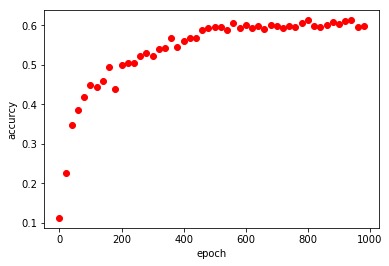

In [49]:
with tf.Session() as sess:
    sess.run(init)
    
    #train
    for i in range(num_epochs):
        batch_x, batch_y = get_batches(x=x_train, y=y_train, batch_size=batch_size, replacement=False)
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y,
            drop_rate: dropout_prob_train
        })
        
        #progress output
        if i % epochs_between_output == 0:
            print("step: {}".format(i))
            matches = tf.equal(tf.argmax(y_true, 1), tf.argmax(logits, 1))
            acc_op = tf.reduce_mean(tf.cast(matches, dtype=tf.float32))
            acc_val = sess.run(acc_op, feed_dict={
                x: x_test,
                y_true: y_test,
                drop_rate: dropout_prob_test
            })
            accuracies.append(acc_val)
            print("acc: {}".format(acc_val))
            plt.plot([i], accuracies[-1], "o", color="red")
            plt.xlabel("epoch")
            plt.ylabel("accurcy")